In [1]:
#imports
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
seed_value = 2020
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
#utils functions
def midPrice(lob_data):
    a=lob_data['AP1'].values.tolist()
    b=lob_data['BP1'].values.tolist()
    m=np.zeros(len(a))
    for i in range(len(a)):
        m[i]=(a[i]+b[i])/2
    return m
def upDown(m):
    u_d=np.zeros(len(a))
    for i in range(1,len(a)):
        if m[i-1]>m[i]:#scende il prezzo
            u_d[i-1]=-1
        elif m[i-1]<m[i]:#sale il prezzo
            u_d[i-1]=1
        else:
            u_d[i-1]=0
    return u_d

def ret(m):
    r=np.zeros(len(m))
    for i in range(1,len(m)):
        r[i]=m[i-1]-m[i]
    return r

def deltaT(m):
    N=0
    d=np.zeros(len(m))
    for i in range(1,len(m)):
        d[i]=m[i-1]-m[i]
        if [i]!=0:
            N+=1
    return int((2.34*10**7)/N)

def doHk(deltT,k):
    hk=np.zeros(k)
    for i in range(k):
        hk[i]=np.int16((1/5)*i*deltT)
    return hk

def retHk(m,hk):
    ret=np.zeros(100)
    for i,k in zip(range(len(m)),hk):
        ret[i]=m[i+k]-m[i]
    return ret

def OF_1(ld):
    of=np.zeros((len(ld),6))
    for i,ii in zip(range(1,12,2),range(0,6,2)): #giro sui prezzi ask e volumi ask di conseguenza
        for j in range(1,len(ld)): #giro sulle righe
            #ask
            if ld[j][i-1]>ld[j-1][i-1]: #p_t>p_t-1
                of[j-1][ii]=-1*ld[j][i]
            elif ld[j][i-1]<ld[j-1][i-1]: #p_t<p_t-1
                of[j-1][ii]=ld[j][i]
            elif ld[j][i-1]==ld[j-1][i-1]: #p_t=p_t-1
                of[j-1][ii]=ld[j][i]-ld[j-1][i]
    for w,ww in zip(range(3,12,4),range(1,7,2)):
        for jj in range(1,len(ld)):    
            #bid
            if ld[jj][w-1]>ld[jj-1][w-1]: #p_t>p_t-1
                of[jj-1][ww]=ld[jj][w]
            elif ld[jj][w-1]<ld[jj-1][w-1]: #p_t<p_t-1
                of[jj-1][ww]=-1*ld[jj][w]
            elif ld[jj][w-1]==ld[jj-1][w-1]: #p_t=p_t-1
                of[jj-1][ww]=ld[jj][w]-ld[jj-1][w]
    return of
    
from scipy import stats
def taglia_e_cuci(v):
    hi=np.quantile(v,0.0005)
    lo=np.quantile(v, 0.9995)
    b=np.clip(v, hi,lo)
    z=normalizer.fit_transform((b.values.reshape(-1,1))).flatten().tolist()
    return b

def MSEbmk(r):
    rBar=np.mean(r)
    h=[ 22, 44, 89, 133, 178, 223, 267, 312, 356, 401]
    emq=np.empty(len(h))
    for i,ii in zip(range(1,len(r)),h):
        emq[i]=((rBar-r[0,ii])/rBar)**2#*(1/(len(r)-1))
    return emq

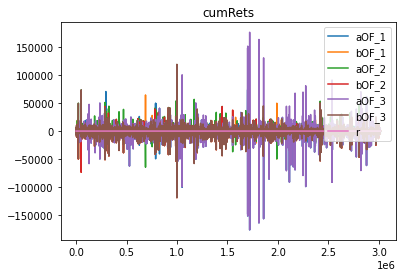

In [3]:
#load data e fa midprice/diff cum
lob_data=pd.read_csv('/Users/macri/Desktop/PROJECT/out_Nuovo.csv') #out_1 out_Nuovo
lob_data.reset_index(drop=True,inplace=True)
lob_data.drop(['Unnamed: 0'], axis=1,inplace=True)
C= int(len(lob_data))
b=lob_data.iloc[ :C].copy()
ld=b.values.tolist()
lob_data=b
ld=lob_data.values.tolist()
aa=OF_1(ld) #fa Order Flow
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(aa, columns=bCols)
m=pd.DataFrame(midPrice(lob_data),columns=['m'])#.plot()
m['r']=m['m'].pct_change()#diff()#calcola le differenze di midprice ogni 10 eventi ->differenze secondo il vettore h_K
m['rCum']=m['r'].cumsum()
of_data['r']=m['rCum']#*100
of_data.dropna(inplace=True)
of_data.plot()
plt.title('cumRets')
plt.show()

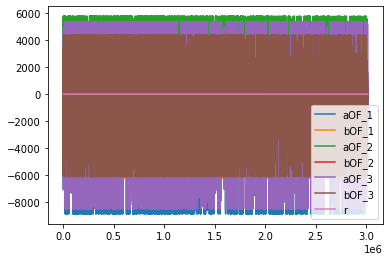

In [4]:
offlo=of_data.apply(lambda x: taglia_e_cuci(x))
offlo.plot();

In [5]:
#fa dataset
y=offlo['r'].to_numpy()
idx=10000
horiz=1
r=np.empty((idx,horiz))
med=np.empty((idx,horiz))
h=[ 22]#, 44, 89, 133, 178, 223, 267, 312, 356, 401]

for i in range(idx): #righe
    for ii,iii in zip(range(horiz),h): #colonne, steps
        r[i,ii]=y[i+iii]-y[i]
        med[i][ii]=np.mean(y[:i+iii])

x_vec=offlo[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:1000000]
x=x_vec.to_numpy()
x_vecc=x.reshape(-1,100, 6, 1)
erre=r

r.shape, x_vecc.shape, med.shape

((10000, 1), (10000, 100, 6, 1), (10000, 1))

In [6]:
##fa supervised dataset: train, val e test
#l=len(x_vecc)
#a=int(9900)
#b=int(99)
#sd= np.std(x_vecc[:a])
#x_vecc_train=x_vecc[:a]
#r_train     =r[:a]
#x_vecc_val  =x_vecc[a:a+b]
#r_val       =r[a:a+b]
#x_vecc_test =x_vecc[a+b:a+b+1]
#r_test      =r[a+b:a+b+1]
#print(x_vecc_train.shape, r_train.shape)
#print(x_vecc_val.shape,   r_val.shape)
#print(x_vecc_test.shape,  r_test.shape)
#
#fa supervised dataset: train, val e test
l=len(x_vecc)
a=int(9000)
b=int(999)
x_vecc_train=x_vecc[:a]

mu=x_vecc_train.mean()
sd=x_vecc_train.std()
stdize=lambda x: x/sd


x_vecc_train=x_vecc[:a]/sd
r_train     =r[:a]
x_vecc_val  =x_vecc[a:a+b]/sd
r_val       =r[a:a+b]
x_vecc_test =x_vecc[a+b:a+b+1]/sd
r_test      =r[a+b:a+b+1]


#fflo=of_data.apply(lambda x: (x-x.mean())/x.std())
print(x_vecc_train.shape, r_train.shape)
print(x_vecc_val.shape,   r_val.shape)
print(x_vecc_test.shape,  r_test.shape)


(9000, 100, 6, 1) (9000, 1)
(999, 100, 6, 1) (999, 1)
(1, 100, 6, 1) (1, 1)


In [7]:
#architettura della rete
def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.7, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    #  LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)
    # output layer
    out = Dense(1, activation='leaky_relu')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='mse')#, metrics=['accuracy']

    return model
  
deeplob = create_nn(100, 6,64)

deeplob.summary()
checkpoint_filepath = './model_tensorflow2/weights'


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [8]:
#early stopping: pazienza=3 e check val_loss
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [9]:
#fitta il modello
simple=deeplob.fit(x_vecc_train, r_train, validation_data=(x_vecc_val, r_val),  epochs=50, batch_size=250,callbacks=[callback])#

Epoch 1/50
36/36 [==============================] - 13s 303ms/step - loss: 2.0840e-04 - val_loss: 1.4588e-04
Epoch 2/50
36/36 [==============================] - 11s 294ms/step - loss: 4.6812e-05 - val_loss: 6.2891e-05
Epoch 3/50
36/36 [==============================] - 10s 291ms/step - loss: 3.9378e-05 - val_loss: 4.2228e-05
Epoch 4/50
36/36 [==============================] - 11s 294ms/step - loss: 2.4101e-05 - val_loss: 2.7934e-05
Epoch 5/50
36/36 [==============================] - 10s 286ms/step - loss: 1.7464e-05 - val_loss: 2.9028e-05
Epoch 6/50
36/36 [==============================] - 11s 304ms/step - loss: 1.2991e-05 - val_loss: 1.9790e-05
Epoch 7/50
36/36 [==============================] - 10s 285ms/step - loss: 1.0891e-05 - val_loss: 1.5985e-05
Epoch 8/50
36/36 [==============================] - 10s 279ms/step - loss: 8.9671e-06 - val_loss: 1.2938e-05
Epoch 9/50
36/36 [==============================] - 10s 280ms/step - loss: 8.4134e-06 - val_loss: 1.4207e-05
Epoch 10/50
36/36 [

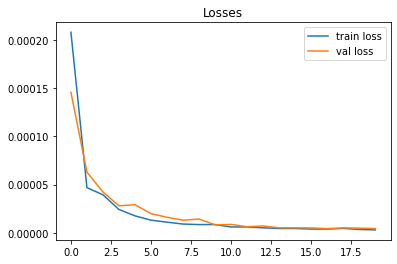

In [10]:
#plotta le loss
plt.plot(simple.history['loss'], label='train loss')
plt.plot(simple.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses');

In [11]:
Ptrain= deeplob.predict(x_vecc_train)
Ptest = deeplob.predict(x_vecc_test)

1/1 [==============================] - 0s 15ms/step


In [12]:
true=r_test#normalizer.inverse_transform(r_test.reshape(-1,1)).flatten()
fcst=Ptest#normalizer.inverse_transform(Ptest.reshape(-1,1)).flatten()
u=np.array([np.mean(true)]*10).flatten()
num=(true-fcst)**2
den=(r[0][-1:].flatten()-med[0])**2
r2OutS=((den-num)/den)#/100
#plt.plot(r2OutS[0][:3])
#plt.ylabel('R2OS(%)')
#plt.xlabel('time');

In [13]:
r2OutS#[ 0.0098595 ,  0.00823161,  0.00815754,  0.00929568,  0.00314167, 0.01577701,  0.00574935, -0.00066972,  0.00438371,  0.00244725]

array([[-41.7719468]])

In [14]:

#def calcola_mse(y_true,y_pred):
#    ms=np.zeros(10)
#    for i in range(1,10):
#        ms[i]=mse(y_true[:i+1],y_pred[:i+1])
#    return ms
#def calcola_mse1(y_true,y_pred):
#    ms=np.zeros(10)
#    for i in range(1,10):
#        ms[i]=((y_true[i]-y_pred[i])/y_pred[i])**2
#    return ms
##calcola_mse1(true,u)[0]=0
#r2os=1-calcola_mse(true,fcst)[1:]/calcola_mse1(true,u)[1:]
#r2osVero=pd.DataFrame(r2os.flatten(),columns=['r2'])
#r2osVero.plot();
#

In [15]:
((0.46756288-0.4674387)*100)**2/((0.00663348)*100)**2

0.0003504454799903377

In [16]:
(((0.00663348))**2-((0.46756288-0.4674387))**2)/((0.00663348))*100

0.6631155326917393

In [17]:
#np.mean(offlo['r'][:22*10])


In [18]:
#num=true-fcst

In [19]:
#den=r[0][-1:].flatten()-med[0]#np.mean(offlo['r'][:22*10])

In [20]:
#true-np.mean(r_test)

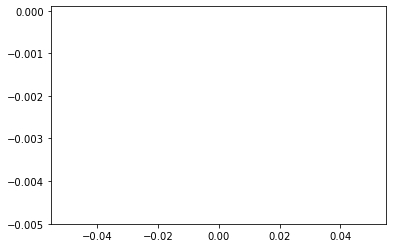

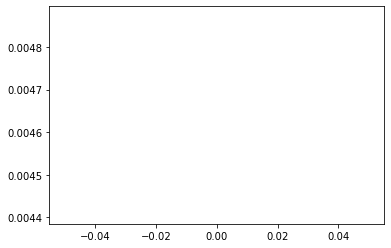

In [21]:
plt.plot(true)
plt.plot(fcst)
plt.show()
plt.plot(np.abs(true-fcst));

In [ ]:
calcola_mse1(true,u),calcola_mse(true,fcst)

NameError: name 'calcola_mse1' is not defined

In [ ]:
true[]-u

In [ ]:
((np.abs((true-u)/true)**2)/(np.abs((true-fcst)/true)**2))

array([1.84865109e-01, 1.51112922e-03, 4.95174832e-04, 3.01143362e-01,
       2.73755168e-04, 1.51237513e-03, 6.97705809e-04, 1.80564546e-03,
       5.61644064e-05, 1.05073229e-03])

In [ ]:
true,fcst,u

(array([0.46756288, 0.46745092, 0.46747339, 0.46717042, 0.46759684,
        0.46736218, 0.46757467, 0.46775381, 0.46753005, 0.46761972]),
 array([0.4674387 , 0.4659443 , 0.46585113, 0.46655256, 0.46231714,
        0.47115013, 0.46510702, 0.4620041 , 0.46478632, 0.4642192 ],
       dtype=float32),
 array([0.46750949, 0.46750949, 0.46750949, 0.46750949, 0.46750949,
        0.46750949, 0.46750949, 0.46750949, 0.46750949, 0.46750949]))

In [ ]:
np.abs((true-u))

array([5.33943548e-05, 5.85676105e-05, 3.60993932e-05, 3.39064527e-04,
       8.73556107e-05, 1.47310704e-04, 6.51806761e-05, 2.44321980e-04,
       2.05623088e-05, 1.10227304e-04])

In [ ]:
#Ptrain= deeplob.predict(x_vecc_train)
#Ptest = deeplob.predict(x_vecc_test)
#from sklearn.metrics import mean_squared_error as me
#def calcola_mse(y_true,y_pred):
#    ms=np.zeros(10)
#    for i in range(10):
#        ms[i]=me(y_true[0][:i+1],y_pred[0][:i+1])
#    return ms
#num=calcola_mse(r_test,Ptest)
#den=calcola_mse(r_train,Ptrain)
#r2=1-(num/den)
#r2.flatten()
#plt.plot(r2);

In [ ]:
r2

NameError: name 'r2' is not defined

In [ ]:
np.mean(offlo['r'][:401])

0.004611162169076948